# <font color = gree>PRDL & MLLB courses ETSIT - UPM</font>
> <font color=orange size= 4>One approach to Compare ML models for OSA Apnea Index Regression</font>
---


* ### We will use the data in: OSA_Regression.xlsx</font>




---
---
Load : OSA_Regression.xlsx  from your Laptop



In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving OSA_Regression.xlsx to OSA_Regression.xlsx
User uploaded file "OSA_Regression.xlsx" with length 28966 bytes


In [2]:
ls

OSA_Regression.xlsx  sample_data/


---

### Read the *OSA_Regression.xlsx* file

In [3]:
# Import pandas
import pandas as pd

# Read OSA_Regression.xlsx
df_OSA = pd.read_excel("OSA_Regression.xlsx")


In [4]:
df_OSA.head(10)

,IAH,Weight,Height,Cervical,Gender,Age,BMI
0,29.6,119,174,48.0,0,56,39.305060
1,19.7,78,168,42.0,0,39,27.636054
2,9.0,80,173,40.0,0,32,26.729927
3,2.0,109,190,42.0,0,32,30.193906
4,34.0,86,169,42.0,0,39,30.110991
5,60.0,145,172,44.0,0,47,49.012980
6,22.0,72,165,42.0,0,40,26.446281
7,11.0,80,180,38.0,0,28,24.691358
8,3.7,90,180,40.0,0,36,27.777778
9,7.0,50,158,35.0,1,50,20.028842


In [5]:
df_OSA.describe()

,IAH,Weight,Height,Cervical,Gender,Age,BMI
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,20.147346,87.704508,171.168614,40.631886,0.285476,49.502504,29.891201
std,18.144753,18.412257,9.502857,3.969171,0.452018,12.349546,5.630683
min,0.000000,45.000000,144.000000,30.000000,0.000000,20.000000,18.590125
25%,6.400000,75.000000,165.000000,38.000000,0.000000,40.000000,26.070325
50%,14.300000,86.000000,171.000000,41.000000,0.000000,49.000000,28.734672
75%,30.000000,98.000000,178.000000,43.000000,1.000000,59.000000,32.770513
max,108.400000,165.000000,197.000000,53.000000,1.000000,88.000000,63.654952


* # Indicate the features we will use

In [6]:
### Picking predictor columns

# Get all the columns from the dataframe.
columns = df_OSA.columns.tolist()

# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in ["IAH"]]

# Store the variable we'll be predicting on.
target = "IAH"

print('Predictors: ',columns)

Predictors:  ['Weight', 'Height', 'Cervical', 'Gender', 'Age', 'BMI']


## We will use data (our features) as Numpy arrays

In [7]:
import numpy as np

X = np.array(df_OSA[columns])


In [8]:
X.shape

(599, 6)

* ### The outcome "y" will be the Apnea Index (IAH)

In [9]:
y = np.array(df_OSA['IAH'])

# Consider those ML models requiring <font color=red>feature normalization</font>

# For this example we will follow <font color=magenta>Nested or Double Loop Crossvalidation</font> as you can read in this blog:

https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/

In [10]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


# configure the OUTER cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)

In [15]:
for train_ix, test_ix in cv_outer.split(X):

  print(test_ix)
  print(len(test_ix))

  break

[  0  13  23  41  47  49  59  62  65  66 111 120 132 135 147 162 165 185
 200 201 214 218 232 237 241 245 257 277 286 292 293 295 314 318 334 355
 374 379 383 394 414 422 430 434 437 439 441 442 448 450 465 472 474 479
 488 502 522 527 530 544]
60


In [16]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


# configure the OUTER cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()

# OUTER LOOP ======================================
for train_ix, test_ix in cv_outer.split(X):
	# split data
	X_train, X_test = X[train_ix, :], X[test_ix, :]
	y_train, y_test = y[train_ix], y[test_ix]

	# INNER LOOP ====================================
	# configure the INNER cross-validation procedure
	cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
	# define the model
	model = RandomForestRegressor(random_state=1)
	# define search space
	space = dict()
	space['n_estimators'] = [100, 250, 500, 600]
	space['max_features'] = [2, 3, 4]
	# define search object
	search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', cv=cv_inner, refit=True)
	# execute search
	result = search.fit(X_train, y_train)

	# get the best performing model fit on the INNER LOOP
	best_model = result.best_estimator_

	# evaluate model on the hold out (OUTER LOOP) dataset
	yhat = best_model.predict(X_test)
	# evaluate the model
	MAE = mean_absolute_error(y_test, yhat)
	# store the result
	outer_results.append(MAE)
	# report progress
	print('>MAE=%.3f, est=%.3f, cfg=%s' % (MAE, result.best_score_, result.best_params_))

# summarize the estimated performance of the model
print('Performace in MAE: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

KeyboardInterrupt: ignored

In [ ]:
space

{'n_estimators': [100, 250, 500, 600], 'max_features': [2, 3, 4]}

# TRY XGBoost

https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/



In [ ]:
! pip install xgboost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X):
	# split data
  X_train, X_test = X[train_ix, :], X[test_ix, :]
  y_train, y_test = y[train_ix], y[test_ix]
	# configure the cross-validation procedure
  cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
	# define the model
  model = XGBRegressor(objective ='reg:squarederror',random_state=1)
	# define search space
  space = dict()
  space['n_estimators'] = [100, 250, 500, 600]
  space['learning_rate'] = [0.01, 0.05, 0.1, 0.3]
  space['max_depth'] = [2, 3, 5, 6]

  # define search
  search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', cv=cv_inner, refit=True)
	# execute search
  result = search.fit(X_train, y_train)

  # get the best performing model fit on the whole training set
  best_model = result.best_estimator_
	# evaluate model on the hold out dataset
  yhat = best_model.predict(X_test)
	# evaluate the model
  MAE = mean_absolute_error(y_test, yhat)
	# store the result
  outer_results.append(MAE)
	# report progress
  print('>MAE=%.3f, est=%.3f, cfg=%s' % (MAE, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Performace in MAE: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

>MAE=10.946, est=-12.149, cfg={'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
>MAE=11.911, est=-12.169, cfg={'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
>MAE=13.042, est=-12.017, cfg={'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
>MAE=10.659, est=-12.132, cfg={'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
>MAE=11.547, est=-12.472, cfg={'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
>MAE=11.429, est=-12.207, cfg={'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
>MAE=12.835, est=-11.781, cfg={'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
>MAE=10.413, est=-12.404, cfg={'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
>MAE=13.271, est=-12.211, cfg={'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
>MAE=12.787, est=-12.054, cfg={'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
Performace in MAE: 11.884 (0.993)


# You can read: In Depth: Parameter tuning for SVC
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769

In [ ]:
from sklearn.svm import SVR

# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X):
	# split data
  X_train, X_test = X[train_ix, :], X[test_ix, :]
  y_train, y_test = y[train_ix], y[test_ix]
	# configure the cross-validation procedure
  cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
	# define the model

  model = SVR()
	# define search space
  space = dict()
  space['C'] = [0.1, 1, 10, 100, 1000]
  space['kernel'] = ['rbf', 'linear']
  space['gamma'] = [1, 0.1, 0.01, 0.001, 0.0001]

  # define search
  search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', cv=cv_inner, refit=True)
	# execute search
  result = search.fit(X_train, y_train)

  # get the best performing model fit on the whole training set
  best_model = result.best_estimator_
	# evaluate model on the hold out dataset
  yhat = best_model.predict(X_test)
	# evaluate the model
  MAE = mean_absolute_error(y_test, yhat)
	# store the result
  outer_results.append(MAE)
	# report progress
  print('>MAE=%.3f, est=%.3f, cfg=%s' % (MAE, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Performace in MAE: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

>MAE=10.393, est=-12.020, cfg={'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
>MAE=12.096, est=-11.679, cfg={'C': 1, 'gamma': 1, 'kernel': 'linear'}
>MAE=12.098, est=-11.801, cfg={'C': 10, 'gamma': 1, 'kernel': 'linear'}
>MAE=10.317, est=-11.944, cfg={'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
>MAE=12.248, est=-11.706, cfg={'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
>MAE=12.055, est=-11.645, cfg={'C': 1, 'gamma': 1, 'kernel': 'linear'}
>MAE=12.404, est=-11.743, cfg={'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
>MAE=10.851, est=-12.024, cfg={'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
>MAE=12.559, est=-11.539, cfg={'C': 10, 'gamma': 1, 'kernel': 'linear'}
>MAE=12.615, est=-11.705, cfg={'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Performace in MAE: 11.763 (0.843)


* # <font color = magenta>**The Lasso Linear Regression**</font> in  [Scikit Learn Linear Models](https://scikit-learn.org/stable/modules/linear_model.html)



In [ ]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X):
	# split data
  X_train, X_test = X[train_ix, :], X[test_ix, :]
  y_train, y_test = y[train_ix], y[test_ix]
	# configure the cross-validation procedure
  cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
	# define the model
  model = make_pipeline(StandardScaler(with_mean=False), Lasso())

	# define search space
  space = dict()

  space['lasso__alpha']= [0.005, 0.01, 0.015, 0.02, 0.03]


  # define search
  search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', cv=cv_inner, refit=True)
	# execute search
  result = search.fit(X_train, y_train)

  # get the best performing model fit on the whole training set
  best_model = result.best_estimator_
	# evaluate model on the hold out dataset
  yhat = best_model.predict(X_test)
	# evaluate the model
  MAE = mean_absolute_error(y_test, yhat)
	# store the result
  outer_results.append(MAE)
	# report progress
  print('>MAE=%.3f, est=%.3f, cfg=%s' % (MAE, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Performace in MAE: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

>MAE=10.510, est=-12.365, cfg={'lasso__alpha': 0.005}
>MAE=12.953, est=-12.158, cfg={'lasso__alpha': 0.005}
>MAE=13.450, est=-12.166, cfg={'lasso__alpha': 0.01}
>MAE=11.053, est=-12.350, cfg={'lasso__alpha': 0.03}
>MAE=11.870, est=-12.061, cfg={'lasso__alpha': 0.005}
>MAE=11.795, est=-12.044, cfg={'lasso__alpha': 0.005}
>MAE=12.480, est=-12.145, cfg={'lasso__alpha': 0.005}
>MAE=10.305, est=-12.478, cfg={'lasso__alpha': 0.005}
>MAE=13.469, est=-11.989, cfg={'lasso__alpha': 0.005}
>MAE=13.394, est=-12.182, cfg={'lasso__alpha': 0.01}
Performace in MAE: 12.128 (1.150)


In [ ]:
space

{'lasso__alpha': [0.005, 0.01, 0.015, 0.02, 0.03]}

# Training and tuning a Decission Tree
https://medium.com/analytics-vidhya/decisiontree-classifier-working-on-moons-dataset-using-gridsearchcv-to-find-best-hyperparameters-ede24a06b489

> * # and visualizing the Tree

https://mljar.com/blog/visualize-decision-tree/


In [17]:
from sklearn.tree import DecisionTreeRegressor

# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X):
	# split data
  X_train, X_test = X[train_ix, :], X[test_ix, :]
  y_train, y_test = y[train_ix], y[test_ix]
	# configure the cross-validation procedure
  cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
	# define the model
  model = DecisionTreeRegressor(random_state=1)
	# define search space
  space = dict()
  space['max_leaf_nodes'] = list(range(2, 100))
  space['min_samples_split'] = [2, 3, 4]


  # define search
  search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', cv=cv_inner, refit=True)
	# execute search
  result = search.fit(X_train, y_train)

  # get the best performing model fit on the whole training set
  best_model = result.best_estimator_
	# evaluate model on the hold out dataset
  yhat = best_model.predict(X_test)
	# evaluate the model
  MAE = mean_absolute_error(y_test, yhat)
	# store the result
  outer_results.append(MAE)
	# report progress
  print('>MAE=%.3f, est=%.3f, cfg=%s' % (MAE, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Performace in MAE: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

>MAE=11.993, est=-12.440, cfg={'max_leaf_nodes': 6, 'min_samples_split': 4}
>MAE=12.532, est=-12.614, cfg={'max_leaf_nodes': 6, 'min_samples_split': 2}
>MAE=13.881, est=-12.440, cfg={'max_leaf_nodes': 8, 'min_samples_split': 2}
>MAE=10.951, est=-12.654, cfg={'max_leaf_nodes': 9, 'min_samples_split': 3}
>MAE=12.328, est=-13.094, cfg={'max_leaf_nodes': 4, 'min_samples_split': 2}
>MAE=12.693, est=-12.530, cfg={'max_leaf_nodes': 11, 'min_samples_split': 2}
>MAE=13.022, est=-12.396, cfg={'max_leaf_nodes': 8, 'min_samples_split': 2}
>MAE=11.248, est=-12.744, cfg={'max_leaf_nodes': 11, 'min_samples_split': 4}
>MAE=14.313, est=-11.911, cfg={'max_leaf_nodes': 5, 'min_samples_split': 2}
>MAE=13.807, est=-12.516, cfg={'max_leaf_nodes': 6, 'min_samples_split': 4}
Performace in MAE: 12.677 (1.056)


# Train a tree with "best hyperparameters" using all data

In [18]:
clf = DecisionTreeRegressor(max_leaf_nodes = 13, min_samples_split = 2, random_state=1)

model = clf.fit(X, y)


* # and <font color = magenta>visualize</font> the tree

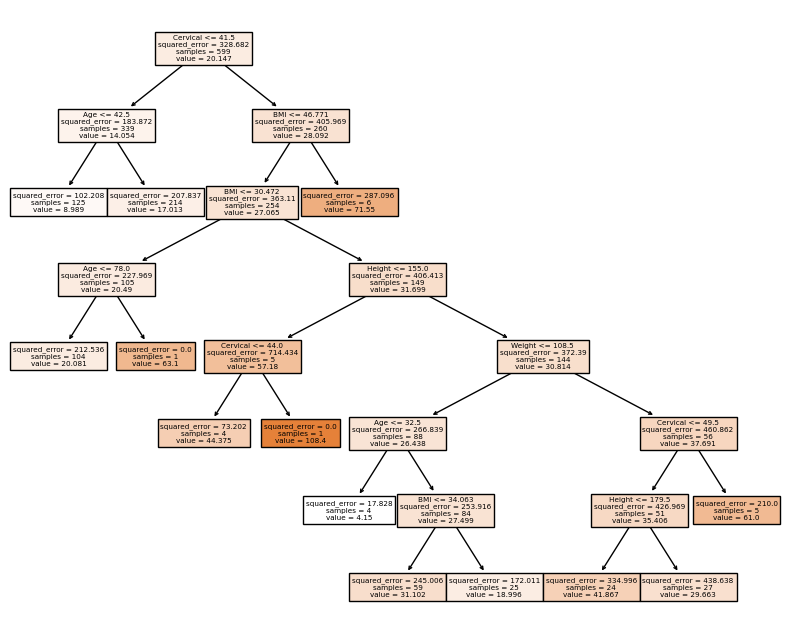

In [20]:
import matplotlib.pyplot as plt
from sklearn import tree

fig = plt.figure(figsize=(10,8))
_ = tree.plot_tree(model,
                   feature_names = columns,
                   filled=True)


In [21]:
! pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.0 MB/s eta 0:00:00


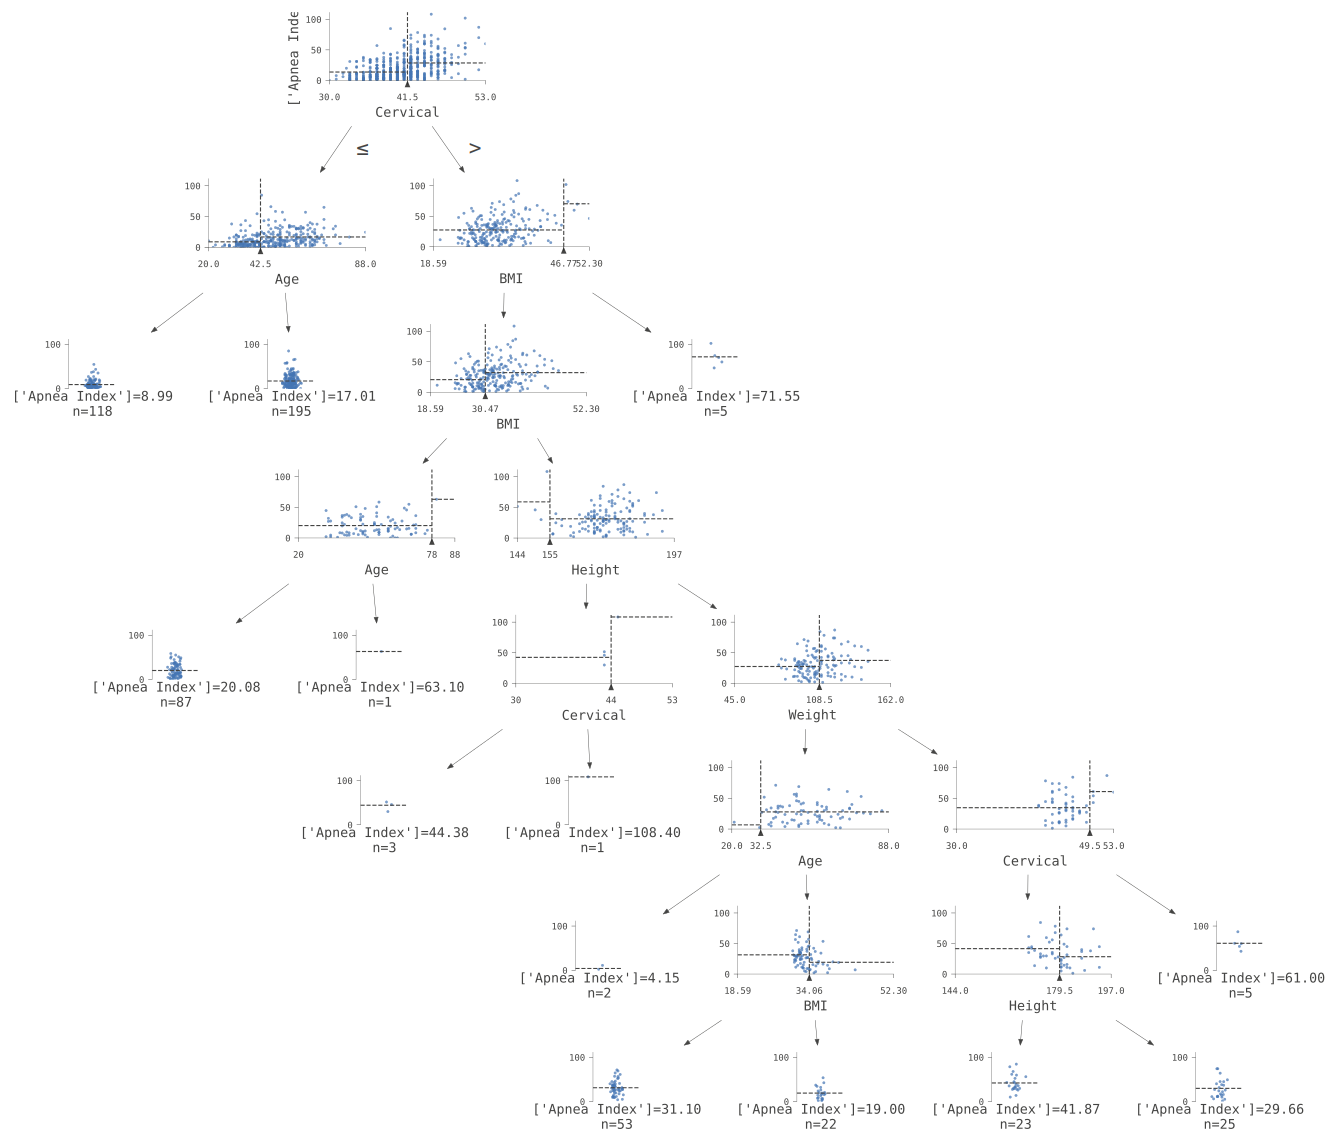

In [22]:
import dtreeviz


viz = dtreeviz.model(model,
               X_train,
               y_train,
               target_name= ['Apnea Index'],  # this name will be displayed at the leaf node
               feature_names = columns,
              )

viz.view(scale=1.5,fontname="monospace")

# You can read more about using Dtreeviz at:
https://www.tensorflow.org/decision_forests/tutorials/dtreeviz_colab

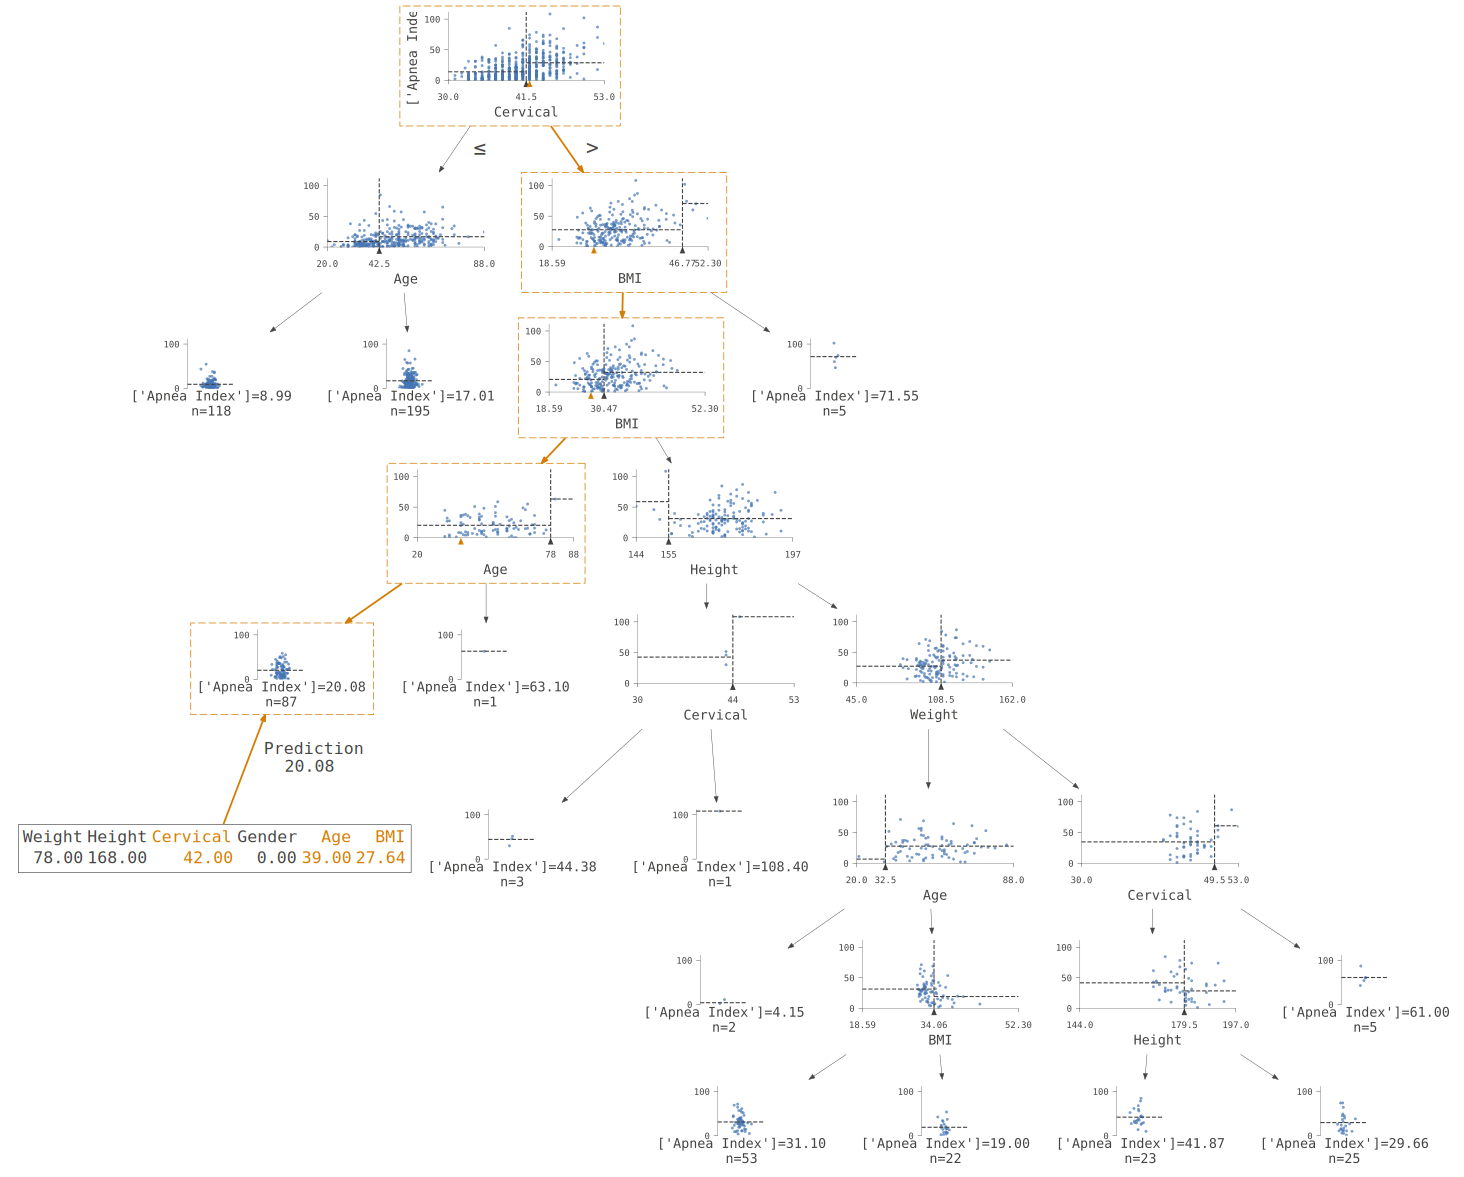

In [23]:
# FOR EXAMPLE: how to visualize a given data X[index]

index = 1
viz.view(x=X[index], scale=1.5,fontname="monospace")


# You can try using <font color=magenta>Bayesian Optimization </font>

https://machinelearningmastery.com/scikit-optimize-for-hyperparameter-tuning-in-machine-learning/